<a href="https://colab.research.google.com/github/atryt0ne/cs690-multimodal-integration/blob/main/code/scMODAL_PBMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IGNORE THESE INSTRUCTIONS: DATA IS DOWNLOADED VIA GDOWN# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
atrytone_bmc_rna_path = kagglehub.dataset_download('atrytone/bmc-rna')

print('Data source import complete.')


Demonstrates performance of scMODAL on the citeSeq PBMC dataset

In [ ]:
!git clone https://github.com/gefeiwang/scMODAL.git

fatal: destination path 'scMODAL' already exists and is not an empty directory.


In [ ]:
!cp -r scMODAL/scmodal scmodal

In [ ]:
!pip install anndata scanpy numba umap-learn torch annoy gdown

Instructions to generate this preprocessed data are in scMODAL_PBMC_CCA

In [ ]:
!gdown 1Rcai7zJP713kiuYkHoTf2phrPcvrszrt
!gdown 1zh4yBkxL6aRkOdjigO8J3Bk876m-j_tG

In [ ]:
import anndata
import scanpy as sc
import numpy as np
import pandas as pd

In [ ]:
rna_adata = sc.read_h5ad("pbmc_protein.h5ad")
protein_adata = sc.read_h5ad("pbmc_protein.h5ad")

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# row sum for RNA
rna_counts = rna_adata.X.sum(axis=1)
# row sum for protein
protein_counts = protein_adata.X.sum(axis=1)
# take median of each and then take mean
target_sum = (np.median(rna_counts.copy()) + np.median(protein_counts.copy())) / 2

In [ ]:
# process rna_shared
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.scale(rna_adata)
# plot UMAPs of rna cells based only on rna markers with protein correspondence
sc.pp.neighbors(rna_adata, n_neighbors=15)
sc.tl.umap(rna_adata)
sc.pl.umap(rna_adata, color=['celltype.l1','celltype.l2'])

/opt/conda/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 234 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


In [ ]:
# process protein_shared
sc.pp.normalize_total(protein_adata)
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)
# plot UMAPs of protein cells based only on protein markers with rna correspondence

sc.pp.neighbors(protein_adata, n_neighbors=15)
sc.tl.umap(protein_adata)
sc.pl.umap(protein_adata, color=['celltype.l1','celltype.l2'])

## Model Training

In [ ]:
import scmodal

model = scmodal.model.Model()
model.preprocess(rna_adata, protein_adata, shared_gene_num=180)
model.train() # train the model
model.eval() # get integrated latent representation of cells

step 2000, loss_D=1.338202, loss_GAN=-1.331120, loss_AE=9.062990, loss_Geo=-19.497242, loss_LA=0.034419, loss_MNN=0.232214
step 4000, loss_D=1.312576, loss_GAN=-1.307880, loss_AE=9.049614, loss_Geo=-19.491638, loss_LA=0.235298, loss_MNN=0.177081
step 6000, loss_D=1.352095, loss_GAN=-1.348437, loss_AE=8.559067, loss_Geo=-19.497290, loss_LA=0.056205, loss_MNN=0.211280
step 8000, loss_D=1.384988, loss_GAN=-1.384494, loss_AE=8.387317, loss_Geo=-19.496639, loss_LA=0.015974, loss_MNN=0.229206
Ending time:  Tue Oct 29 18:07:16 2024
Training takes 1435.80 seconds
Begining time:  Tue Oct 29 18:07:16 2024
Ending time:  Tue Oct 29 18:07:16 2024
Evaluating takes 0.03 seconds


/kaggle/working/scmodal/model.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.E_A.load_state_dict(torch.load(os.path.join(self.model_path, "ckpt.pth"))['E_A'])
/k

## Model Evaluation

In [ ]:
adata_int = anndata.AnnData(X=model.latent)
adata_int.obs = pd.concat([rna_adata.obs, protein_adata.obs])
adata_int.obs['modality'] = ['RNA'] * rna_adata.shape[0] + ['ADT'] * protein_adata.shape[0]

scmodal.utils.compute_umap(adata_int)

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation', min_dist=0.3, n_jobs=1, n_neighbors=30, random_state=1234, repulsion_strength=1, verbose=True)
Tue Oct 29 18:07:16 2024 Construct fuzzy simplicial set
Tue Oct 29 18:07:16 2024 Finding Nearest Neighbors
Tue Oct 29 18:07:16 2024 Building RP forest with 12 trees


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Tue Oct 29 18:07:16 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Tue Oct 29 18:07:29 2024 Finished Nearest Neighbor Search
Tue Oct 29 18:07:31 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Oct 29 18:07:54 2024 Finished embedding


... storing 'modality' as categorical


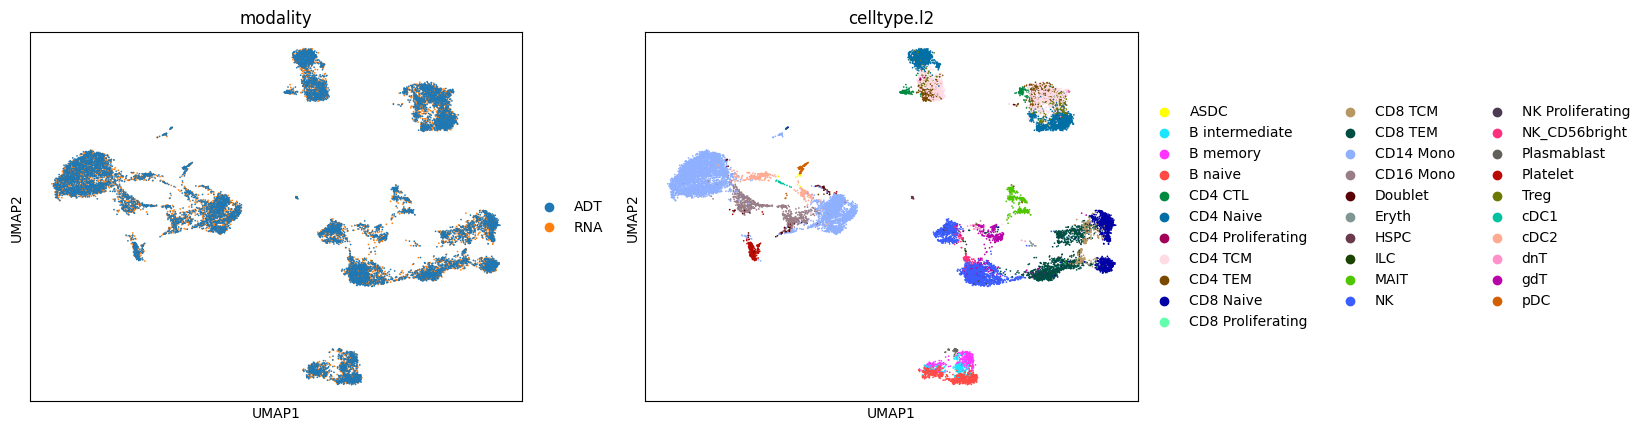

In [ ]:
sc.pl.umap(adata_int,color=['modality','celltype.l2'])

In [ ]:
from scipy.spatial.distance import cdist

dist_mtx = cdist(model.latent[rna_adata.shape[0]:, :],
                 model.latent[:rna_adata.shape[0], :],
                 metric='euclidean') # Transfer labels from RNA to ADT

matching = dist_mtx.argsort()[:, :1]

df1_labels = rna_adata.obs["celltype.l1"].values
df2_labels = protein_adata.obs["celltype.l1"].values

print("Label transfer accuracy: ", np.sum(df1_labels == df2_labels[matching.reshape(-1)]) / rna_adata.shape[0])

Label transfer accuracy:  0.9978


In [ ]:
df1_labels_2 = rna_adata.obs["celltype.l2"].values
df2_labels_2 = protein_adata.obs["celltype.l2"].values

print("Label transfer accuracy: ", np.sum(df1_labels_2 == df2_labels_2[matching.reshape(-1)]) / rna_adata.shape[0])

Label transfer accuracy:  0.9796


### FOSCTTM

In [ ]:
rna_cca, protein_cca = model.latent[rna_adata.shape[0]:, :], model.latent[:rna_adata.shape[0], :]

In [ ]:
# rna_cca, protein_cca = fusor.get_embedding(
#     active_arr1=fusor.active_arr1,
#     active_arr2=fusor.active_arr2
# )

In [ ]:
def cdist_correlation(arr1, arr2):
    """Calculate pair-wise 1 - Pearson correlation between X and Y.

    Parameters
    ----------
    arr1: np.array of shape (n_samples1, n_features)
        First dataset.
    arr2: np.array of shape (n_samples2, n_features)
        Second dataset.

    Returns
    -------
    array-like of shape (n_samples1, n_samples2)
        The (i, j)-th entry is 1 - Pearson correlation between i-th row of arr1 and j-th row of arr2.
    """
    n, p = arr1.shape
    m, p2 = arr2.shape
    assert p2 == p

    arr1 = (arr1.T - np.mean(arr1, axis=1)).T
    arr2 = (arr2.T - np.mean(arr2, axis=1)).T

    arr1 = (arr1.T / np.sqrt(1e-6 + np.sum(arr1 ** 2, axis=1))).T
    arr2 = (arr2.T / np.sqrt(1e-6 + np.sum(arr2 ** 2, axis=1))).T

    return 1 - arr1 @ arr2.T

def get_foscttm(dist, true_matching='identity'):
    """
    Compute the fraction of samples closer than true match.

    Parameters
    ----------
    dist: np.ndarray of shape (n1, n2)
        Distance matrix.
    true_matching: 'identity' or Iterable of length n1, default='identity'
        If is a list, then the ground truth matched pairs are (i, true_matching[i])
        If is 'identity', then true_matching = [0, 1..., n1].

    Returns
    -------
    The fraction of samples closer than true match.
    """
    n1, _ = dist.shape
    if true_matching == 'identity':
        true_matching = np.arange(n1)
    elif isinstance(true_matching, Iterable):
        true_matching = [i for i in true_matching]
    else:
        raise NotImplementedError('true_matching must be \'identity\' or Iterable of length dist.shape[0].')
    # mask[i, j] = True iff dist[i, j] < dist[i, true_matching[i]]
    mask = (dist.T < dist[np.arange(n1), true_matching]).T
    return np.mean(np.mean(mask, axis=1))

dim_use = 15 # dimensions of the CCA embedding to be used for UMAP etc

get_foscttm(
    dist=cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),
    true_matching='identity'
)

0.0009216100000000001